In [1]:
import sys
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

import operator
import itertools
import functools

In [2]:
import FIS
import FuzzySet
import StateVariable

In [3]:
from Environment import CartPole

## Load Environment

In [4]:
env = CartPole()

## Create Fuzzy Inference System

In [5]:
x1 = StateVariable.InputStateVariable(FuzzySet.Trapeziums(-2.4, -2, -1, -0.5), FuzzySet.Trapeziums(-1, -0.5, 0.5, 1), FuzzySet.Trapeziums(0.5, 1, 2, 2.4))
x2 = StateVariable.InputStateVariable(FuzzySet.Triangles(-2.4, -0.5, 1), FuzzySet.Triangles(-0.5, 1, 2.4))
x3 = StateVariable.InputStateVariable(FuzzySet.Triangles(-3.14159, -1.5, 0), FuzzySet.Triangles(-1.5, 0, 1.5), FuzzySet.Triangles(0, 1.5, 3.1459))
x4 = StateVariable.InputStateVariable(FuzzySet.Triangles(-3.14159, -1.5, 0), FuzzySet.Triangles(-1.5, 0, 1.5), FuzzySet.Triangles(0, 1.5, 3.1459))

In [6]:
fis = FIS.Build(x1, x2, x3, x4)

## Define Fuzzy Q Learning

In [7]:
class FQL(object):
    
    L = []
    R = []
    R_ = []
    M = []
    Q = 0
    V = 0
    
    error = 0
    Q_table = np.matrix([])
    
    def __init__(self, gamma, alpha, ee_rate, Q_initial_value, action_set_length, fis = FIS.Build()):
        
        self.gamma = gamma
        self.alpha = alpha
        self.ee_rate = ee_rate
        self.Q_initial_value = Q_initial_value
        self.action_set_length = action_set_length
        self.fis = fis
        
        if self.Q_initial_value == 'random':
            self.Q_table = np.random.random((self.fis.get_number_of_rules(), self.action_set_length))
        if self.Q_initial_value == 'zero':
            self.Q_table = np.zeros((self.fis.get_number_of_rules(), self.action_set_length))
            
    def calculate_truth_value(self, state_value):
        
        self.L = []
        self.R = []
        
        input_variables = self.fis.list_of_input_variable
        for index, variable in enumerate(input_variables):
            
            X = []
            fuzzy_sets = variable.get_fuzzy_sets()
            for fset in fuzzy_sets:
                membership_value = fset.get_membership_value(state_value[index])
                X.append(membership_value)
                
            self.L.append(X)
            
        for el in itertools.product(*self.L):
            self.R.append(functools.reduce(operator.mul, el, 1))
            
    def select_action(self):
        
        self.M = []
        r = random.uniform(0, 1)
        sys_max = -sys.maxsize
        
        for cell in self.Q_table:
            if r < self.ee_rate:
                for index, action in enumerate(cell):
                    if action > sys_max:
                        action_index = index
            else:
                action_index = random.randint(0, self.action_set_length - 1)
            
            self.M.append(action_index)
            
    def infer_action(self):
        
        sys_max = -sys.maxsize
        for index, truth_value in enumerate(self.R):
            if truth_value > sys_max:
                sys_max = truth_value
                action = self.M[index]
                
        return action
    
    def calculate_Q_value(self):
        
        self.Q = 0
        for index, truth_value in enumerate(self.R):
            self.Q = self.Q + truth_value * self.Q_table[index, self.M[index]]
        self.Q = self.Q / sum(self.R)
        
    def calculate_state_value(self):
        
        self.V = 0
        sys_max = -sys.maxsize
        for index, cell in enumerate(self.Q_table):
            for action in cell:
                if action < sys_max:
                    sys_max = action
            self.V = (self.R[index] * sys_max) + self.V
        
        if sum(self.R) == 0:
            self.R[0] = 1e-5
        self.V = self.V / sum(self.R)
        
    def calculate_quality_variation(self, reward):
        self.error = reward + ((self.gamma * self.V) - self.Q)
        
    def update_Q_value(self):
        
        for index, truth_value in enumerate(self.R_):
            
            Q_delta = self.alpha * (self.error * truth_value)
            self.Q_table[index][self.M[index]] = self.Q_table[index][self.M[index]] + Q_delta
            
    def keep_state_history(self):
        
        self.R_ = copy.copy(self.R)
        
    def get_initial_action(self, state):
        
        self.calculate_truth_value(state)
        self.select_action()
        action = self.infer_action()
        
        self.calculate_Q_value()
        self.keep_state_history()
        
        return action
    
    def run(self, state, reward):
        
        self.calculate_truth_value(state)
        self.calculate_state_value()
        self.calculate_quality_variation(reward)
        self.update_Q_value()
        
        self.select_action()
        action = self.infer_action()
        
        self.calculate_Q_value()
        self.keep_state_history()
        
        return action

In [8]:
model = FQL(gamma=0.9, alpha=0.1, ee_rate=0.999, Q_initial_value='random', action_set_length=21, fis=fis)

## Train The Model

In [9]:
num_episodes = 5000
state_value_list = []

reward_to_plot = []

In [10]:
for i_episode in range(num_episodes):
    
    if i_episode%100 == 0 or reward == -1:
        
        env.__init__()
        
        action = model.get_initial_action(env.state)
        reward, state_value = env.apply_action(action)
        
    action = model.run(state_value, reward)
    reward, state_value = env.apply_action(action)
    
    reward_to_plot.append(reward)
    
    if reward != -1: 
        state_value_list.append(state_value[2])

## Evaluate The Model

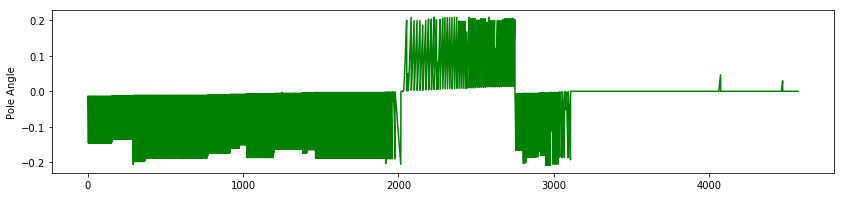

In [11]:
plt.figure(figsize=(14,3))
plt.plot(state_value_list, color='green')
plt.ylabel('Pole Angle')
plt.show()

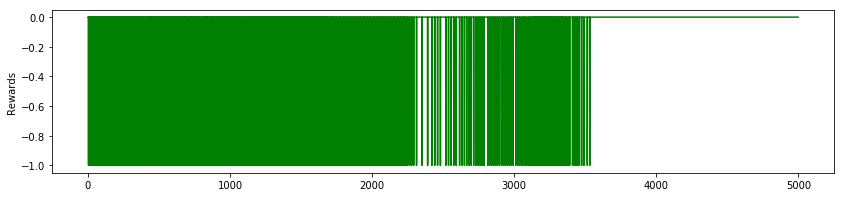

In [12]:
plt.figure(figsize=(14,3))
plt.plot(reward_to_plot, color='green')
plt.ylabel('Rewards')
plt.show()

---